# Deal with Audio data

In [20]:
import os
import numpy as np
import torch
import librosa
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor, TrainingArguments, Trainer
from datasets import Dataset
from evaluate import load
from matplotlib import pyplot as plt
import seaborn as sns

# 設定設備（GPU 或 CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [2]:
# 設定模型名稱（選擇預訓練的 Wav2Vec 2.0 模型）
model_name = "facebook/wav2vec2-base"  # 可換成更高版本，如 'facebook/wav2vec2-large'
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name, num_labels=5).to(device)

/Users/liang/anaconda3/envs/Audio/lib/python3.8/site-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 資料準備
train_data_folder = "data/training_data"  
train_wav_files = [os.path.join(train_data_folder, f) for f in os.listdir(train_data_folder) if f.endswith(".wav")]
train_labels = np.load("train_label.npy")  

test_data_folder = "data/test_data_public" 
test_wav_files = [os.path.join(test_data_folder, f) for f in os.listdir(test_data_folder) if f.endswith(".wav")]
test_labels = np.load("test_label.npy")

In [4]:
print(len(train_wav_files))
print(len(train_labels))
print(len(test_wav_files))
print(len(test_labels))

1000
1000
500
500


In [5]:
def preprocess_audio(file_paths, labels):
    audio_features = []
    for file in file_paths:
        # 讀取音檔
        audio, sr = librosa.load(file, sr=16000)
        target_length = int(16000 * 2)  # 2 秒的樣本數 (16kHz * 2秒 = 32000樣本)

        if len(audio) < target_length:
            # 如果音檔少於 2 秒，補齊中間部分
            extra_length = target_length - len(audio)  # 計算需要補充的樣本數
            middle_index = len(audio) // 2
            middle_section = audio[middle_index - extra_length // 2 : middle_index + extra_length // 2]
            
            # 如果中間段不足以補齊，重複補充
            if len(middle_section) < extra_length:
                middle_section = np.tile(middle_section, int(np.ceil(extra_length / len(middle_section))))[:extra_length]
            
            # 將中間部分插入到音檔中
            audio = np.concatenate((audio[:middle_index], middle_section, audio[middle_index:]))
        elif len(audio) > target_length:
            # 如果音檔超過 2 秒，刪除中間部分
            excess_length = len(audio) - target_length  # 計算需要刪除的樣本數
            middle_index = len(audio) // 2
            audio = np.concatenate((audio[:middle_index - excess_length // 2], audio[middle_index + excess_length // 2:]))
        
        # 處理為 Wav2Vec2 的輸入格式
        inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        # 儲存處理後的輸入和標籤
        audio_features.append({
            "input_values": inputs["input_values"].squeeze(0).numpy(),
            "label": labels[file_paths.index(file)]
        })
    return audio_features


In [ ]:
# 處理訓練與測試數據
train_data = preprocess_audio(train_wav_files, train_labels)
test_data = preprocess_audio(test_wav_files, test_labels)

# 轉換為 Hugging Face Dataset 格式
train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)

In [7]:
# 評估指標
metric = load("accuracy")

def compute_metrics(pred):
    logits = pred.predictions
    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=pred.label_ids)

# 訓練參數
training_args = TrainingArguments(
    output_dir="./wav2vec_finetune",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

/Users/liang/anaconda3/envs/Audio/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# 初始化 Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset, # include labels
    eval_dataset=test_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics
)

# 開始微調
trainer.train()

# 評估模型
trainer.evaluate()

# 儲存微調後的模型
model.save_pretrained("./wav2vec_finetuned")
processor.save_pretrained("./wav2vec_finetuned")
print("Fine-tuned model saved!")

/var/folders/bj/bvc7yd313cn8_2_tq0c2q48m0000gn/T/ipykernel_17359/3932407925.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▏         | 10/625 [00:22<09:28,  1.08it/s] 

{'loss': 1.4924, 'grad_norm': 59.615657806396484, 'learning_rate': 9.84e-06, 'epoch': 0.08}


  3%|▎         | 20/625 [00:30<07:29,  1.35it/s]

{'loss': 1.2933, 'grad_norm': 75.7059097290039, 'learning_rate': 9.68e-06, 'epoch': 0.16}


  5%|▍         | 30/625 [00:37<07:13,  1.37it/s]

{'loss': 1.214, 'grad_norm': 72.78775024414062, 'learning_rate': 9.52e-06, 'epoch': 0.24}


  6%|▋         | 40/625 [00:45<07:13,  1.35it/s]

{'loss': 1.2653, 'grad_norm': 85.59074401855469, 'learning_rate': 9.360000000000002e-06, 'epoch': 0.32}


  8%|▊         | 50/625 [00:52<07:03,  1.36it/s]

{'loss': 1.2229, 'grad_norm': 99.1572036743164, 'learning_rate': 9.200000000000002e-06, 'epoch': 0.4}


 10%|▉         | 60/625 [00:59<06:55,  1.36it/s]

{'loss': 1.2468, 'grad_norm': 116.02562713623047, 'learning_rate': 9.040000000000002e-06, 'epoch': 0.48}


 11%|█         | 70/625 [01:07<06:48,  1.36it/s]

{'loss': 1.1921, 'grad_norm': 145.36940002441406, 'learning_rate': 8.880000000000001e-06, 'epoch': 0.56}


 13%|█▎        | 80/625 [01:14<06:36,  1.37it/s]

{'loss': 1.1163, 'grad_norm': 156.96310424804688, 'learning_rate': 8.720000000000001e-06, 'epoch': 0.64}


 14%|█▍        | 90/625 [01:21<06:28,  1.38it/s]

{'loss': 1.1017, 'grad_norm': 193.04095458984375, 'learning_rate': 8.560000000000001e-06, 'epoch': 0.72}


 16%|█▌        | 100/625 [01:29<06:26,  1.36it/s]

{'loss': 1.0273, 'grad_norm': 268.50653076171875, 'learning_rate': 8.400000000000001e-06, 'epoch': 0.8}


 18%|█▊        | 110/625 [01:36<06:20,  1.35it/s]

{'loss': 1.2045, 'grad_norm': 279.28936767578125, 'learning_rate': 8.24e-06, 'epoch': 0.88}


 19%|█▉        | 120/625 [01:43<06:05,  1.38it/s]

{'loss': 1.1904, 'grad_norm': 338.6160583496094, 'learning_rate': 8.08e-06, 'epoch': 0.96}


                                                 
 20%|██        | 125/625 [02:03<05:46,  1.44it/s]

{'eval_loss': 1.129379153251648, 'eval_accuracy': 0.536, 'eval_runtime': 15.8821, 'eval_samples_per_second': 31.482, 'eval_steps_per_second': 3.967, 'epoch': 1.0}


 21%|██        | 130/625 [02:09<16:48,  2.04s/it]

{'loss': 1.1233, 'grad_norm': 462.25970458984375, 'learning_rate': 7.92e-06, 'epoch': 1.04}


 22%|██▏       | 140/625 [02:16<06:15,  1.29it/s]

{'loss': 0.9985, 'grad_norm': 580.4761962890625, 'learning_rate': 7.76e-06, 'epoch': 1.12}


 24%|██▍       | 150/625 [02:24<05:49,  1.36it/s]

{'loss': 1.0745, 'grad_norm': 680.0540161132812, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.2}


 26%|██▌       | 160/625 [02:31<05:45,  1.35it/s]

{'loss': 1.0223, 'grad_norm': 764.9988403320312, 'learning_rate': 7.440000000000001e-06, 'epoch': 1.28}


 27%|██▋       | 170/625 [02:38<05:33,  1.37it/s]

{'loss': 1.1693, 'grad_norm': 796.041015625, 'learning_rate': 7.280000000000001e-06, 'epoch': 1.36}


 29%|██▉       | 180/625 [02:46<05:29,  1.35it/s]

{'loss': 1.1496, 'grad_norm': 1034.78662109375, 'learning_rate': 7.1200000000000004e-06, 'epoch': 1.44}


 30%|███       | 190/625 [02:53<05:17,  1.37it/s]

{'loss': 1.1536, 'grad_norm': 1396.461669921875, 'learning_rate': 6.96e-06, 'epoch': 1.52}


 32%|███▏      | 200/625 [03:00<05:12,  1.36it/s]

{'loss': 1.1568, 'grad_norm': 1882.2242431640625, 'learning_rate': 6.800000000000001e-06, 'epoch': 1.6}


 34%|███▎      | 210/625 [03:08<05:06,  1.35it/s]

{'loss': 1.2301, 'grad_norm': 2413.865234375, 'learning_rate': 6.640000000000001e-06, 'epoch': 1.68}


 35%|███▌      | 220/625 [03:15<04:58,  1.36it/s]

{'loss': 1.1002, 'grad_norm': 2415.16552734375, 'learning_rate': 6.480000000000001e-06, 'epoch': 1.76}


 37%|███▋      | 230/625 [03:23<04:40,  1.41it/s]

{'loss': 1.0904, 'grad_norm': 3387.02783203125, 'learning_rate': 6.3200000000000005e-06, 'epoch': 1.84}


 38%|███▊      | 240/625 [03:30<04:32,  1.41it/s]

{'loss': 1.0754, 'grad_norm': 3110.0791015625, 'learning_rate': 6.16e-06, 'epoch': 1.92}


 40%|████      | 250/625 [03:37<04:14,  1.47it/s]

{'loss': 1.0836, 'grad_norm': 4035.866943359375, 'learning_rate': 6e-06, 'epoch': 2.0}


                                                 
 40%|████      | 250/625 [03:51<04:14,  1.47it/s]

{'eval_loss': 1.1453428268432617, 'eval_accuracy': 0.536, 'eval_runtime': 14.7437, 'eval_samples_per_second': 33.913, 'eval_steps_per_second': 4.273, 'epoch': 2.0}


 42%|████▏     | 260/625 [04:01<05:29,  1.11it/s]

{'loss': 1.1357, 'grad_norm': 8050.52001953125, 'learning_rate': 5.84e-06, 'epoch': 2.08}


 43%|████▎     | 270/625 [04:08<04:18,  1.37it/s]

{'loss': 1.0871, 'grad_norm': 6926.1962890625, 'learning_rate': 5.68e-06, 'epoch': 2.16}


 45%|████▍     | 280/625 [04:15<04:15,  1.35it/s]

{'loss': 1.0645, 'grad_norm': 9423.7958984375, 'learning_rate': 5.5200000000000005e-06, 'epoch': 2.24}


 46%|████▋     | 290/625 [04:23<03:55,  1.42it/s]

{'loss': 1.1475, 'grad_norm': 9725.1728515625, 'learning_rate': 5.36e-06, 'epoch': 2.32}


 48%|████▊     | 300/625 [04:30<03:50,  1.41it/s]

{'loss': 1.0666, 'grad_norm': 13494.0068359375, 'learning_rate': 5.2e-06, 'epoch': 2.4}


 50%|████▉     | 310/625 [04:37<03:39,  1.43it/s]

{'loss': 1.0549, 'grad_norm': 15325.62109375, 'learning_rate': 5.04e-06, 'epoch': 2.48}


 51%|█████     | 320/625 [04:44<03:34,  1.42it/s]

{'loss': 1.0947, 'grad_norm': 18194.505859375, 'learning_rate': 4.880000000000001e-06, 'epoch': 2.56}


 53%|█████▎    | 330/625 [04:51<03:31,  1.40it/s]

{'loss': 1.1507, 'grad_norm': 16122.14453125, 'learning_rate': 4.7200000000000005e-06, 'epoch': 2.64}


 54%|█████▍    | 340/625 [04:58<03:25,  1.39it/s]

{'loss': 1.0773, 'grad_norm': 21874.25, 'learning_rate': 4.56e-06, 'epoch': 2.72}


 56%|█████▌    | 350/625 [05:05<03:15,  1.41it/s]

{'loss': 1.1233, 'grad_norm': 31142.841796875, 'learning_rate': 4.4e-06, 'epoch': 2.8}


 58%|█████▊    | 360/625 [05:13<03:06,  1.42it/s]

{'loss': 1.1844, 'grad_norm': 43191.72265625, 'learning_rate': 4.24e-06, 'epoch': 2.88}


 59%|█████▉    | 370/625 [05:20<02:56,  1.44it/s]

{'loss': 1.1476, 'grad_norm': 35150.79296875, 'learning_rate': 4.08e-06, 'epoch': 2.96}


                                                 
 60%|██████    | 375/625 [05:37<02:47,  1.50it/s]

{'eval_loss': 1.1519845724105835, 'eval_accuracy': 0.536, 'eval_runtime': 14.5573, 'eval_samples_per_second': 34.347, 'eval_steps_per_second': 4.328, 'epoch': 3.0}


 61%|██████    | 380/625 [05:43<07:47,  1.91s/it]

{'loss': 1.1886, 'grad_norm': 53866.87890625, 'learning_rate': 3.920000000000001e-06, 'epoch': 3.04}


 62%|██████▏   | 390/625 [05:50<02:53,  1.35it/s]

{'loss': 1.1396, 'grad_norm': 47399.6640625, 'learning_rate': 3.7600000000000004e-06, 'epoch': 3.12}


 64%|██████▍   | 400/625 [05:57<02:42,  1.39it/s]

{'loss': 1.0309, 'grad_norm': 51995.828125, 'learning_rate': 3.6000000000000003e-06, 'epoch': 3.2}


 66%|██████▌   | 410/625 [06:04<02:30,  1.43it/s]

{'loss': 1.1727, 'grad_norm': 65624.5703125, 'learning_rate': 3.44e-06, 'epoch': 3.28}


 67%|██████▋   | 420/625 [06:11<02:22,  1.43it/s]

{'loss': 1.2097, 'grad_norm': 78089.1171875, 'learning_rate': 3.2800000000000004e-06, 'epoch': 3.36}


 69%|██████▉   | 430/625 [06:18<02:16,  1.43it/s]

{'loss': 1.0653, 'grad_norm': 66521.78125, 'learning_rate': 3.12e-06, 'epoch': 3.44}


 70%|███████   | 440/625 [06:26<02:11,  1.41it/s]

{'loss': 1.1736, 'grad_norm': 99627.8125, 'learning_rate': 2.96e-06, 'epoch': 3.52}


 72%|███████▏  | 450/625 [06:33<02:03,  1.42it/s]

{'loss': 1.1343, 'grad_norm': 92269.3984375, 'learning_rate': 2.8000000000000003e-06, 'epoch': 3.6}


 74%|███████▎  | 460/625 [06:40<01:54,  1.44it/s]

{'loss': 1.1498, 'grad_norm': 89360.9375, 'learning_rate': 2.64e-06, 'epoch': 3.68}


 75%|███████▌  | 470/625 [06:47<01:46,  1.45it/s]

{'loss': 1.1508, 'grad_norm': 104656.0, 'learning_rate': 2.4800000000000004e-06, 'epoch': 3.76}


 77%|███████▋  | 480/625 [06:54<01:40,  1.44it/s]

{'loss': 1.1279, 'grad_norm': 101129.75, 'learning_rate': 2.3200000000000002e-06, 'epoch': 3.84}


 78%|███████▊  | 490/625 [07:01<01:34,  1.43it/s]

{'loss': 1.138, 'grad_norm': 124776.8671875, 'learning_rate': 2.16e-06, 'epoch': 3.92}


 80%|████████  | 500/625 [07:08<01:29,  1.40it/s]

{'loss': 1.0904, 'grad_norm': 122798.5, 'learning_rate': 2.0000000000000003e-06, 'epoch': 4.0}


                                                 
 80%|████████  | 500/625 [07:23<01:29,  1.40it/s]

{'eval_loss': 1.1653584241867065, 'eval_accuracy': 0.536, 'eval_runtime': 14.7578, 'eval_samples_per_second': 33.88, 'eval_steps_per_second': 4.269, 'epoch': 4.0}


 82%|████████▏ | 510/625 [07:33<01:44,  1.10it/s]

{'loss': 1.2139, 'grad_norm': 115998.3125, 'learning_rate': 1.8400000000000002e-06, 'epoch': 4.08}


 83%|████████▎ | 520/625 [07:40<01:14,  1.41it/s]

{'loss': 1.0708, 'grad_norm': 136141.90625, 'learning_rate': 1.6800000000000002e-06, 'epoch': 4.16}


 85%|████████▍ | 530/625 [07:47<01:06,  1.43it/s]

{'loss': 1.0485, 'grad_norm': 130445.5234375, 'learning_rate': 1.52e-06, 'epoch': 4.24}


 86%|████████▋ | 540/625 [07:54<00:59,  1.43it/s]

{'loss': 1.1747, 'grad_norm': 123861.03125, 'learning_rate': 1.3600000000000001e-06, 'epoch': 4.32}


 88%|████████▊ | 550/625 [08:01<00:53,  1.39it/s]

{'loss': 1.0648, 'grad_norm': 151895.84375, 'learning_rate': 1.2000000000000002e-06, 'epoch': 4.4}


 90%|████████▉ | 560/625 [08:09<00:49,  1.31it/s]

{'loss': 1.1347, 'grad_norm': 109937.6640625, 'learning_rate': 1.04e-06, 'epoch': 4.48}


 91%|█████████ | 570/625 [08:16<00:40,  1.34it/s]

{'loss': 1.1529, 'grad_norm': 139188.828125, 'learning_rate': 8.8e-07, 'epoch': 4.56}


 93%|█████████▎| 580/625 [08:24<00:33,  1.33it/s]

{'loss': 1.1994, 'grad_norm': 135486.546875, 'learning_rate': 7.2e-07, 'epoch': 4.64}


 94%|█████████▍| 590/625 [08:31<00:26,  1.31it/s]

{'loss': 1.2326, 'grad_norm': 155299.234375, 'learning_rate': 5.6e-07, 'epoch': 4.72}


 96%|█████████▌| 600/625 [08:39<00:18,  1.33it/s]

{'loss': 1.1415, 'grad_norm': 137579.03125, 'learning_rate': 4.0000000000000003e-07, 'epoch': 4.8}


 98%|█████████▊| 610/625 [08:46<00:11,  1.35it/s]

{'loss': 1.2008, 'grad_norm': 159957.09375, 'learning_rate': 2.4000000000000003e-07, 'epoch': 4.88}


 99%|█████████▉| 620/625 [08:54<00:03,  1.35it/s]

{'loss': 1.0354, 'grad_norm': 137096.875, 'learning_rate': 8e-08, 'epoch': 4.96}


                                                 
100%|██████████| 625/625 [09:15<00:00,  1.46it/s]

{'eval_loss': 1.1621168851852417, 'eval_accuracy': 0.536, 'eval_runtime': 14.8422, 'eval_samples_per_second': 33.688, 'eval_steps_per_second': 4.245, 'epoch': 5.0}


100%|██████████| 625/625 [09:17<00:00,  1.12it/s]


{'train_runtime': 557.1402, 'train_samples_per_second': 8.974, 'train_steps_per_second': 1.122, 'train_loss': 1.1404777503967285, 'epoch': 5.0}


100%|██████████| 63/63 [00:14<00:00,  4.38it/s]


Fine-tuned model saved!


## Get Embedding

In [12]:
# 確保設備為 MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# 將模型加載到設備
model = model.to(device)

def extract_embeddings(file_paths):
    embeddings = []
    model.eval()
    for file in file_paths:
        audio, sr = librosa.load(file, sr=16000)
        inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        inputs = {key: val.to(device, dtype=torch.float32) for key, val in inputs.items()}  # 保證張量類型一致
        with torch.no_grad():
            outputs = model.wav2vec2(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # 平均池化
            embeddings.append(embedding)
    return np.vstack(embeddings)


Using device: mps


In [13]:
# 提取訓練與測試集嵌入
train_embeddings = extract_embeddings(train_wav_files)
test_embeddings = extract_embeddings(test_wav_files)
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")

Train embeddings shape: (1000, 768)
Test embeddings shape: (500, 768)


In [36]:
# save embeddings to csv
np.savetxt("use_data/train_embeddings.csv", train_embeddings, delimiter=",")
np.savetxt("use_data/test_embeddings.csv", test_embeddings, delimiter=",")

### Visualizing the audio data


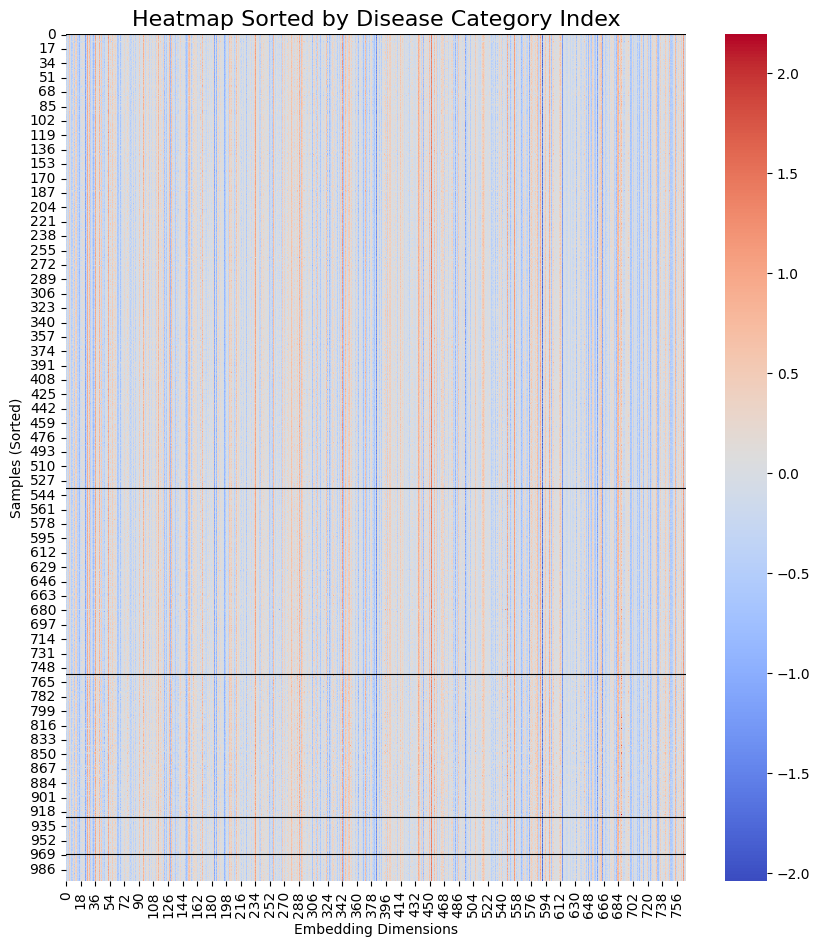

In [35]:
disease_sort_index = np.load("disease_sort_index.npy")
disease_sort = np.load("disease_sort.npy")
group_boundaries = np.cumsum(np.bincount(disease_sort))[:-1]

sorted_embeddings = train_embeddings[disease_sort_index]

# 繪製熱圖
plt.figure(figsize=(10, 11))
ax = sns.heatmap(
    sorted_embeddings,
    annot=False,
    cmap="coolwarm",
    cbar=True
)

# 添加分組分隔線
for boundary in group_boundaries:
    ax.axhline(boundary, color='black', linewidth=0.8)  # 橫向分隔線

plt.title("Heatmap Sorted by Disease Category Index", fontsize=16)
plt.xlabel("Embedding Dimensions")
plt.ylabel("Samples (Sorted)")
plt.show()